# Outlier Detection Practice: univariate & multivariate

Kevin Arvai. [Here](https://www.kaggle.com/kevinarvai/outlier-detection-practice-uni-multivariate)

Common __parametric__ methods use the standard deviation and interquartile range. __Nonparametric__ methods are more involved, but clustering can have adequate performance. This kernel explores both parametric and nonaparametric method on __univariate__ data, then __multivariate__.

## Table of Contents
1. Parametric methods: Univariate
    1. Standard Deviation
    2. Compare Standard Deviation and IQR
2. Nonparametric methods: Univariate
    1. Isolation Forest
3. Parametric methods: Multivariate
    2. EllipticEnvelope
4. Nonparametric methods: Multivariate
    1. DBSCAN
    2. LocalOutlierFactor

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

%matplotlib inline

## 1. Parametric methods: Univariate

Create a dummy dataframe where features have normal distributions to practice parametric methods.

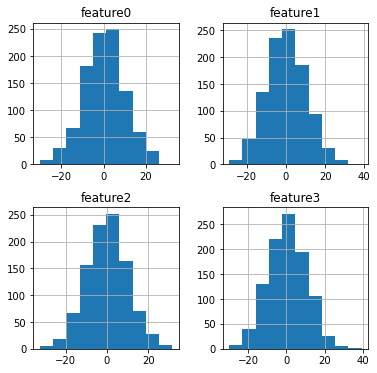

In [2]:
# seed for reproducibility
np.random.seed(42)
n_feats = 4

dummydf = pd.DataFrame(np.random.normal(scale=10.0, size=(1000, n_feats)),
                       columns=['feature{}'.format(i) for i in range(n_feats)])

# all normally distributed
dummydf.hist(figsize=(6,6));

In [3]:
# sns.distplot(dummydf['feature3'], kde=False);
dummydf.head()

,feature0,feature1,feature2,feature3
0,4.967142,-1.382643,6.476885,15.230299
1,-2.341534,-2.341370,15.792128,7.674347
2,-4.694744,5.425600,-4.634177,-4.657298
3,2.419623,-19.132802,-17.249178,-5.622875
4,-10.128311,3.142473,-9.080241,-14.123037


In [4]:
# enough variation between features to show outliers
dummydf.describe()

,feature0,feature1,feature2,feature3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.306239,0.248285,-0.082552,0.300861
std,9.639191,10.118843,10.060754,10.069640
min,-30.195122,-28.962554,-32.412673,-29.911360
25%,-6.129422,-6.770368,-6.752986,-6.708710
50%,0.561874,0.202097,-0.075088,0.211577
75%,6.648813,6.938808,6.422820,6.958780
max,32.430930,38.527315,31.520567,39.262377


Define two functions that statistically identify outliers in a pandas Series using a standard deviation and interquartile range method.

In [5]:
def out_std(s, nstd=3.0, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series using standard deviation, works column-wise.
    param nstd:
        Set number of standard deviations from the mean
        to consider an outlier
    :type nstd: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """

    data_mean, data_std = s.mean(), s.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off

    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]

In [6]:
def out_iqr(s, k=1.5, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series using interquartile range, works column-wise.
    param k:
        some cutoff to multiply by the iqr
    :type k: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """

    # calculate interquartile range
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off

    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return [True if x < lower or x > upper else False for x in s]

Both functions return a list of boolean values.

### 1. Standard Deviation

In [7]:
# This is a quick example of what the output of out_std looks like on 
# randomly generated data from a normal distribution.

# outlier_mask is a boolean list identifies the indices of the outliers
outlier_mask = out_std(dummydf['feature0'], nstd=3.0, return_thresholds=False)

# first 10 elements
outlier_mask[:10]

[False, False, False, False, False, False, False, False, False, False]

In [8]:
# This is a quick example of what the output of out_std looks like on 
# randomly generated data from a normal distribution.

# outlier_mask is a boolean list identifies the indices of the outliers
# outlier_maskiqr = out_iqr(dummydf['feature0'], k=1.5, return_thresholds=False)

# first 10 elements
# outlier_maskiqr[:10]

[False, False, False, False, False, False, False, False, False, False]

Visualize the outliers in the context of the feature's distribution.

506   -30.195122
788   -29.069882
929    32.430930
Name: feature0, dtype: float64


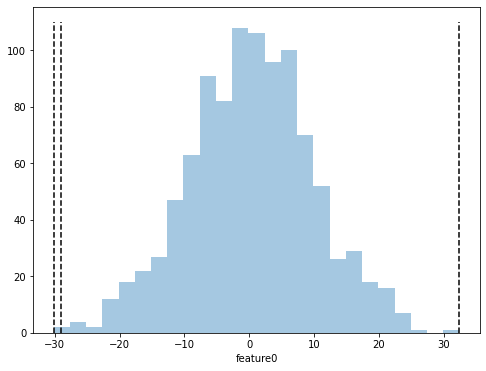

In [9]:
plt.figure(figsize=(8,6))
print(dummydf['feature0'][outlier_mask])
sns.distplot(dummydf['feature0'], kde=False);
plt.vlines(dummydf['feature0'][outlier_mask], ymin=0, ymax=110, linestyles='dashed');

### 2. Compare Standard Deviation and IQR

In [10]:
# For comparison, make one array each using standard deviations of 2.0, 3.0 and 4.0.
std2 = dummydf.apply(out_std, nstd=2.0)
std3 = dummydf.apply(out_std, nstd=3.0)
std4 = dummydf.apply(out_std, nstd=4.0)

In [13]:
# For comparison, make one array each at varying values of k.
iqr1 = dummydf['feature0'].apply(out_iqr, k=1.5)
iqr2 = dummydf['feature0'].apply(out_iqr, k=2.0)
iqr3 = dummydf['feature0'].apply(out_iqr, k=3.0)

TypeError: 'float' object is not iterable

In [ ]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(ncols=3, nrows=2, figsize=(22, 12));
ax1.set_title('Outliers using 2 standard deviations');
ax2.set_title('Outliers using 3 standard deviations');
ax3.set_title('Outliers using 4 standard deviations');
ax4.set_title('Outliers using a 1.5 IQR cutoff');
ax5.set_title('Outliers using a 2.5 IQR cutoff');
ax6.set_title('Outliers using a 3.0 IQR cutoff');

sns.heatmap(std2, cmap='YlGn', ax=ax1);
sns.heatmap(std3, cmap='YlGn', ax=ax2);
sns.heatmap(std4, cmap='YlGn', ax=ax3);
sns.heatmap(iqr1, cmap='YlGn', ax=ax4);
sns.heatmap(iqr2, cmap='YlGn', ax=ax5);
sns.heatmap(iqr3, cmap='YlGn', ax=ax6);

# testing control of newsfeed figure: https://www.kaggle.com/questions-and-answers/57099#post330539
# plt.savefig('outliers.png') 
plt.show()

A detailed visualization of the different standard deviation cutoffs for feature0, note return_thresholds=True in the outlier function:

In [ ]:
def plot_cutoff(dataframe, col, nstd=2.0, color='red'):
    """
    Version 8 update: more generic function.
    Function added in Version 6, more readable code than previous versions.
    From version 4 update: 
    This code block will plot lower and upper thresholds.
    I'm still thinking about how to best visualize this, suggestions welcome!
    """
    lower, upper = out_std(dataframe[col], nstd=nstd, return_thresholds=True)
    plt.axvspan(min(dataframe[col][dataframe[col] < lower], default=dataframe[col].min()), lower, alpha=0.2, color=color);
    plt.axvspan(upper, max(dataframe[col][dataframe[col] > upper], default=dataframe[col].max()), alpha=0.2, color=color);

In [ ]:
column = 'feature0'
sns.distplot(dummydf[column], kde=False)
plot_cutoff(dummydf, column, nstd=2.0, color='red');
plot_cutoff(dummydf, column, nstd=3.0, color='green');
plot_cutoff(dummydf, column, nstd=4.0, color='yellow');

## 2. Nonparametric methods: Univariate

The features in the Melbourne Housing dataset are skewed, they should serve as good distributions to test nonparametric outlier detection method.

In [ ]:
df = pd.read_csv('..\\..\\..\\data\\kaggle-melbourne-housing.csv')
df.shape

In [ ]:
# for this exercise, just fill missing values with the median value for a column.
# Using median ensures filled values will be whole numbers.
df.fillna(df.median(), inplace=True)

In [ ]:
# Limit the detection of outliers to a subset of the columns in this particular dataset.
df.columns

In [ ]:
cols = ['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'Propertycount']

Visualize the distribution of the features.

In [ ]:
df[cols].hist(figsize=(12,10));

### 1. Isolation Forest
[IsolationForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest) is implemented in scikit-learn. It returns an anomaly_score for each data point. Code below is modified from a short tutorial [Here](https://dzone.com/articles/spotting-outliers-with-isolation-forest-using-skle).

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(22, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df[column].values.reshape(-1,1))

    xx = np.linspace(df[column].min(), df[column].max(), len(df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

The chart shows the anomaly scores and the regions where the outliers are. As expected, the anomaly score reflects the shape of the underlying distribution and the outlier regions correspond to low probability areas.

__Note__. <span style='color:red'><b>Notice `PropertyCount` has a bimodal distribution. `OneClassSVM` might perform better in these cases</b></span>.

## 3. Parametric methods: Multivariate

### 2. EllipticEnvelope
__Note__. *For normally distributed data use dummydf*.

In [ ]:
clf = EllipticEnvelope()

legend = {}

xx, yy = np.meshgrid(np.linspace(-35, 35, 500), np.linspace(-35, 35, 500))

plt.figure(1, figsize=(10,10))
clf.fit(dummydf.values[:,:2])
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

legend['EllipticEnvelope'] = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors=['m'])

legend_values_list = list(legend.values())
legend_keys_list = list(legend.keys())

# two clusters
plt.figure(1, figsize=(10,10))

plt.title("Outlier detection on first two columns of dummydf")
plt.scatter(dummydf.values[:, 0], dummydf.values[:, 1], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")

plt.xlim((xx.min(), xx.max()))
plt.ylim((yy.min(), yy.max()))
plt.legend(legend_values_list[0].collections, legend_keys_list, loc="upper center");

plt.ylabel("feature1");
plt.xlabel("feature0");

## 4. Nonparametric methods: Multivariate
### 1. DBSCAN
Note. *DBSCAN on Melbourne Housing Data*

For skewed distributions a quick and dirty method called DBSCAN [Here](http://scikit-learn.org/stable/auto_examples/applications/plot_outlier_detection_housing.html), is a good tutorial for other methods in scikit-learn. This is a quick nonparametric method that can be used in multivariate analyses. Parameters that will significantly affect clusters and worth tuning are `eps` and `min_samples`.

In [ ]:
# scale data first
X = StandardScaler().fit_transform(df[cols].values)

db = DBSCAN(eps=3.0, min_samples=10).fit(X)
labels = db.labels_

In [ ]:
print(labels)
pd.Series(labels).value_counts()

Visualize the outlier samples in the context of the first two features, `Rooms` and `Price`

In [ ]:
plt.figure(figsize=(10,10))

unique_labels = set(labels)
colors = ['blue', 'red']

for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(X[:,0][sample_mask], X[:, 1][sample_mask], 'o', color=color);
plt.xlabel('Standardized Number of Rooms');
plt.ylabel('Standardized Price');

### 2. LocalOutlierFactor
I tried detecting outliers in the first two features again, but LocalOutlierFactor may require fine-tuning.

In [ ]:
clf = LocalOutlierFactor(n_neighbors=50, contamination='auto')
y_pred = clf.fit_predict(X[:,:2])

In [ ]:
plt.figure(figsize=(10,10))

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-3, 14, num=200), np.linspace(-3, 18, num=200))
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c='white', edgecolor='k', s=20)

# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c='red', edgecolor='k', s=20)

plt.axis('tight')
plt.xlabel('Standardized Number of Rooms');
plt.ylabel('Standardized Price');
plt.show()